In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
%matplotlib inline

### 1.1 Read and show data

In [8]:
import csv

y = []
x = []

def onehot(ind, total):
    '''
    return a one hot np array of length total
    '''
    result = np.zeros(total)
    result[ind] = 1.
    return result

with open('mnist_train_small_100.csv') as csv_file:
    csv_reader = csv.reader(csv_file)
    count = 0
    for row in csv_reader:
        count += 1
        y.append(onehot(int(row[0]), 10))
        x.append(np.array(row[1:]).astype(np.float)/255) # Here, we devide by 255 for naive normalization
    print(f'Processed {count} lines.')

Processed 100 lines.


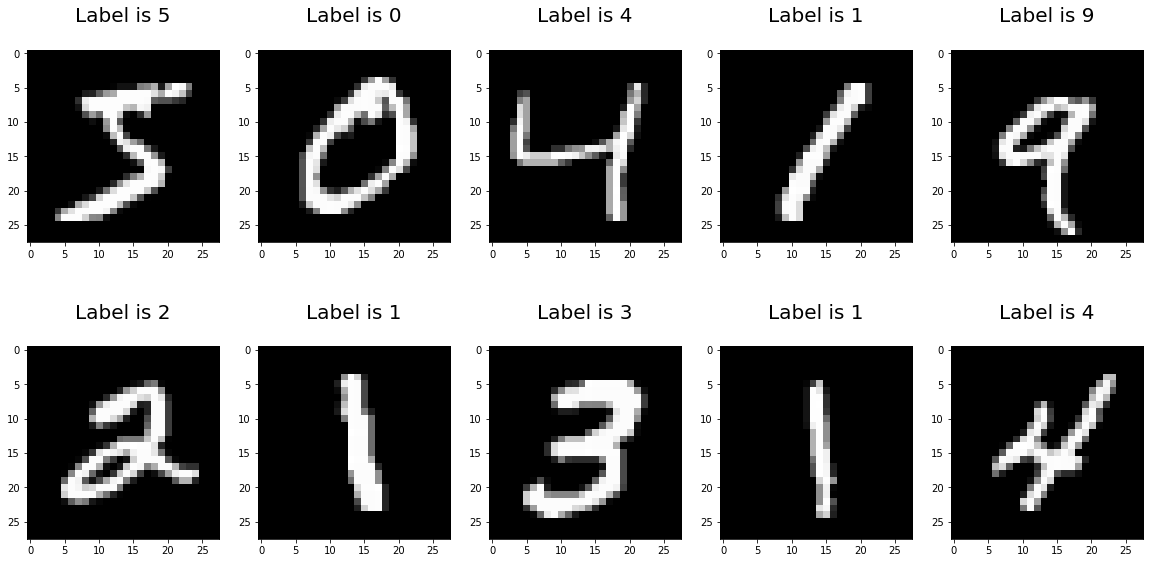

In [9]:
plt.figure(figsize=(20,10))
for index, (image, label) in enumerate(zip(x[:10], y[:10])):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image.reshape([28, 28])*255, cmap=plt.cm.gray) # we multiply 255 for de-normalization
    plt.title('Label is %i\n' % label.argmax(), fontsize = 20)

### 1.2 Likelihood function and derivatives


We will implement the following equations:

- Softmax Function:

\begin{align*}
	softmax_{i}(x) = \frac{e^{x_{i}}}{\sum_{j=1}^{10}e_{x_{j}}}
\end{align*}

- Negative Log Likelihood Function (a.k.a. loss Function):

\begin{align*}
	loss(w) = -\sum_{i=1}^{n}\sum_{j=1}^{10}y_{ij}\log\big(softmax_j(x_i)\big)=-\sum_{i=1}^{n}\left (\sum_{j=1}^{10}y_{ij}\left (w_{j}^{T}x_{i}\right ) - \log\left (\sum_{j=1}^{10}e^{w_{j}^{T}x_{i}}\right )\right )
\end{align*}

- Derivative of Loss Function with respect to w (a.k.a. gradient):

\begin{align*}
	\frac{\partial loss}{\partial w_{j}} = -\sum_{i=1}^{n} \Big (y_{ij} - softmax(w_{j}^{T}x_{i})\Big )\cdot x_{i}
\end{align*}

In [10]:
def softmax_func(X):
    '''
    Inputs:
        X : N * C input matrix
    Output:
        res : N * C result matrix for softmax
    '''
    N = X.shape[0]
    exp = np.exp(X - np.max(X)) # for numerical stability
    exp_sum = np.sum(exp, axis=1).reshape(N, 1)
    return exp / exp_sum

In [11]:
def loss_func(X_prime, y, w):
    '''
    Inputs:
        X_prime : the feature matrix of size N * (D+1)
        y       : the label matrix of size N * C
        w       : the weight matrix of size (D+1) * C
    Output:
        res : the loss value, which is a real number
    '''
    # for the sake of numberical stability, we will use the first formula to calculate loss
    softmax = softmax_func(np.dot(X_prime, w))
    return -np.sum(y * np.log(softmax))

def loss_func_check(X_prime, y, w):
    '''
    We will use the second formula to double check on the correctness of first loss func
    '''
    N = X_prime.shape[0]
    C = y.shape[1]
    
    loss = 0
    for i in range(N):
        tmp = 0.
        for j in range(C):
            loss += y[i][j] * np.sum(w[:,j] * X_prime[i])
            tmp += np.exp(np.sum(w[:,j] * X_prime[i]))
        loss -= np.log(tmp)
    return -loss

In [12]:
def gradient(X_prime, y, w):
    '''
    Inputs:
        X_prime : the feature matrix of size N * (D+1)
        y       : the label matrix of size N * C
        w       : the weight matrix of size (D+1) * C
    Output:
        res : the gradient of loss value with respect to all weights, which has size (D+1) * C
    '''
    softmax = softmax_func(np.dot(X_prime, w))
    return np.dot(X_prime.transpose(), softmax - y)

def gradient_check(X_prime, y, w):
    '''
    The way to check gradient is by definition of gradient, i.e. we will add a small delta 
    to each entry of weight matrix and observe the corresponding change to loss function.
    The estimation of derivative would be: (change in loss) / delta
    '''
    grad = np.zeros_like(w)
    height, width = w.shape
    delta = 0.1e-5
    loss = loss_func(X_prime, y, w)
    
    for i in range(height):
        for j in range(width):
            w[i][j] += delta
            loss_delta = loss_func(X_prime, y, w) - loss
            grad[i][j] = loss_delta / delta
            w[i][j] -= delta
    return grad

In [13]:
# we will combine the calculation of likelihood function and derivative
def step(w, X, y, double_check = False):
    """
    Input:
        w: the weight vector of size (D + 1) * C
        X: the data matrix of size N * D
        y: the label matrix of size N * C where each entry can be either 0 or 1
           representing the label of corresponding feature vector
        double_check: whether we should check the correctness of loss and grad
    Output:
        loss: the scalar value of error function of multi-class logistic regression
        grad: the vector of size (D+1) * C representing the gradient of lose function
    """
    N = X.shape[0]
    D = X.shape[1]
    C = y.shape[1]
    loss = 0
    grad = np.zeros_like(w)
    
    # Firstly, we need to add bias to input data
    X_prime = np.insert(X, 0, 1, axis=1)
    assert(X_prime.shape[0] == N and X_prime.shape[1] == D + 1)
    
    # Next, calculate the loss
    loss = loss_func(X_prime, y, w)
    
    if double_check:
        # Double checking
        loss_diff = np.abs(loss-loss_func_check(X_prime, y, w))
        assert(loss_diff/loss < 1e-5)
        print("Loss assertion passed.")
    
    # we need to average over all samples
    loss /= N
    
    # At last, we calculate the gradient
    grad = gradient(X_prime, y, w)
    
    if double_check:
        # Double checking
        grad_diff = np.abs(grad - gradient_check(X_prime, y, w))
        assert(np.all(grad_diff < 1e-5))
        print("Gradient assertion passed.")

    # Again, we need to average over all samples
    grad /= N
    
    return loss, grad

In [14]:
# Testing
w_tmp = np.array([[1.,2.,3.,1.,2.,3.], 
                  [4.,5.,6.,2.,1.,5.], 
                  [7.,8.,9.,2.,3.,1.], 
                  [2.,3.,7.,8.,9.,1.], 
                  [4.,3.,2.,1.,4.,4.]])                          # (D+1) * C
X_tmp = np.array([[1,2,3,5], [4,5,6,1], [3,7,1,2]])              # N * D
y_tmp = np.array([[0,1,0,0,0,0], [0,0,1,0,0,0], [0,0,0,0,1,0]])  # N * C
_ = step(w_tmp, X_tmp, y_tmp, double_check=True)
# All assertions passed

Loss assertion passed.
Gradient assertion passed.


### 1.3 Model Predicting

In [15]:
def predict(w, X):
    """
    Input:
        w: the weight vector of size (D + 1) * C
        X: the data matrix of size N * D
    Output:        
        res: A vector of predicted result of size N * 1
    """
    N = X.shape[0]
    D = X.shape[1]
    
    X_prime = np.insert(X, 0, 1, axis=1)
    assert(X_prime.shape[0] == N and X_prime.shape[1] == D + 1)
    
    prod = np.dot(X_prime, w)
    prediction = prod.argmax(axis=1).reshape(-1,1)
    return prediction

def correct_count(w, X, y):
    """
    Input:
        w: the weight vector of size (D + 1) * C
        X: the data matrix of size N * D
        y: the label matrix of size N * C where each entry can be either 0 or 1
           representing the label of corresponding feature vector
    Output:        
        res: number of correctly predicted data, which is a real number
    """
    prediction = predict(w, X)
    return int(np.sum([y[i][j] for i,j in enumerate(prediction)]))

### 1.4 Model Fitting

In [16]:
# random shuffle
x,y = np.array(x), np.array(y)
permutation = np.random.permutation(100)
x, y = x[permutation], y[permutation]

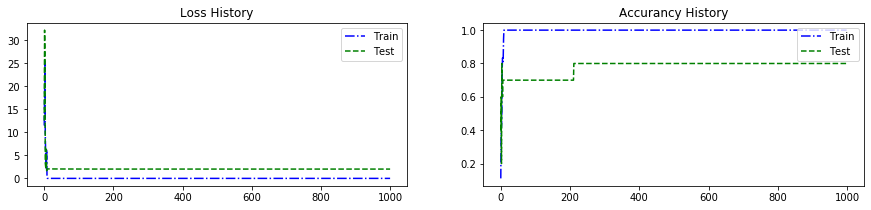

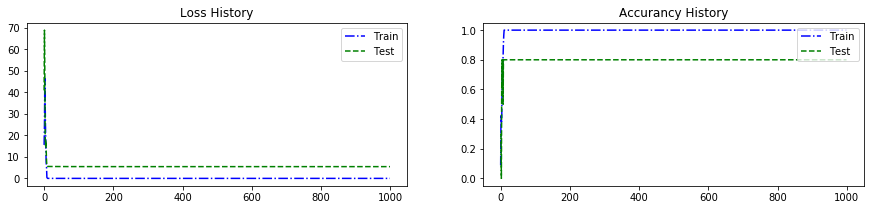

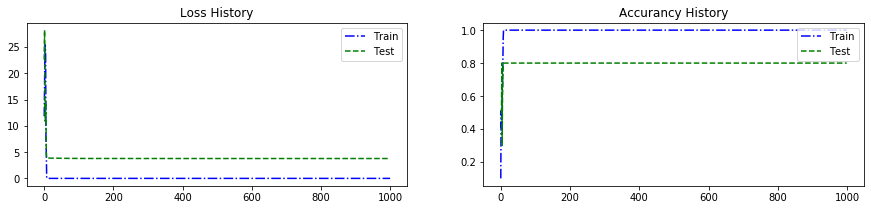

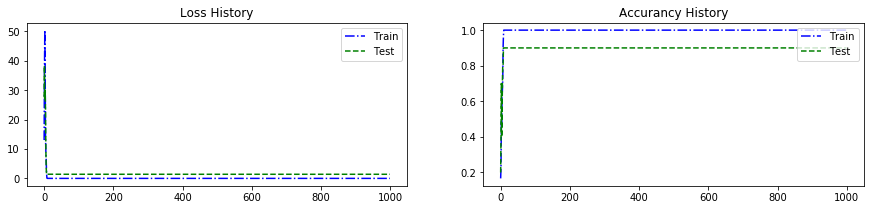

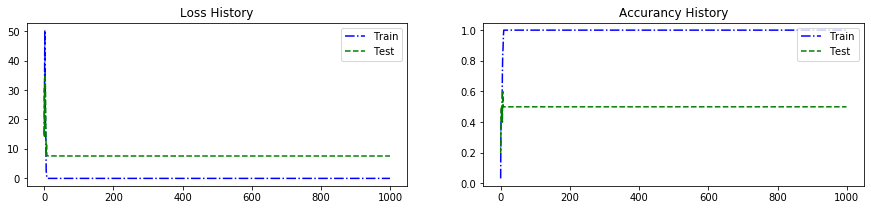

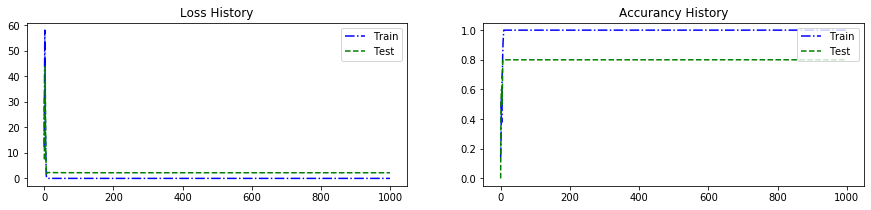

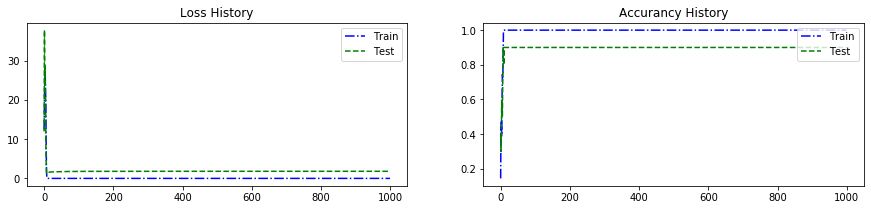

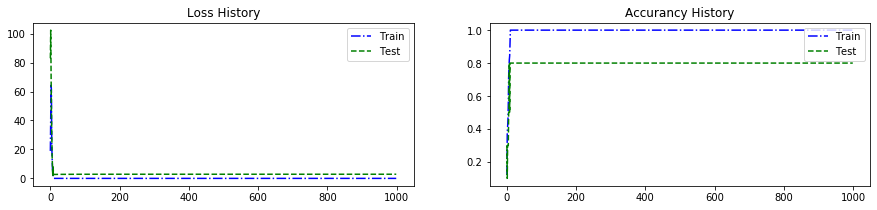

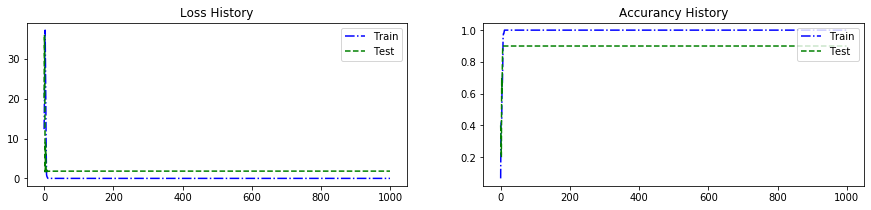

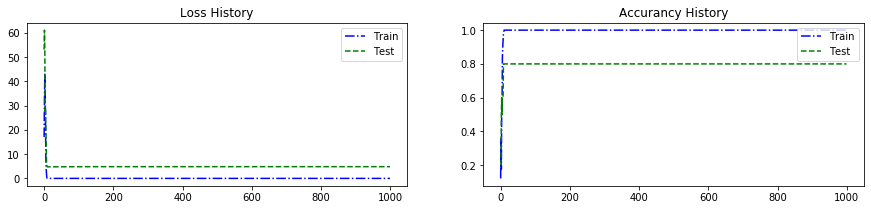

In [17]:
weights = []
training_results = []
evaluation_results = []

# 10-fold cross validation
for fold in range(0, 100, 10):
    mask = np.array([False] * 100)
    mask[fold:fold+10] = True
    X_train = x[~mask]
    y_train = y[~mask]
    X_test = x[mask]
    y_test = y[mask]
    
    # randomly initialize a weight matrix
    weight = np.random.normal(0, 1, [X_train[0].shape[0]+1, 10])
    epoch = 1000
    lr = 10 # learning rate
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for i in range(epoch):
        # decrease learning every 100 epoch
        if (i+1) % 100 == 0:
            lr /= 5

        # training loss and accurancy
        loss, grad = step(weight, X_train, y_train)
        acc = float(correct_count(weight, X_train, y_train)) / X_train.shape[0]
        train_loss.append(loss)
        train_acc.append(acc)

        # update weight matrix
        weight -= lr * grad

        # test loss and accurancy
        loss, _ = step(weight, X_test, y_test)
        acc = float(correct_count(weight, X_test, y_test)) / X_test.shape[0]
        test_loss.append(loss)
        test_acc.append(acc)
    
    # plotting training process
    fig = plt.figure(figsize=(15, 3))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(range(epoch), train_loss, 'b-.', range(epoch), test_loss, 'g--')
    ax.legend(('Train', 'Test'), loc='upper right')
    ax.set_title('Loss History')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(range(epoch), train_acc, 'b-.', range(epoch), test_acc, 'g--')
    ax.legend(('Train', 'Test'), loc='upper right')
    ax.set_title('Accurancy History')

    weights.append(weight)
    training_results.append(train_acc[-1])
    evaluation_results.append(test_acc[-1])

In [18]:
print("Average accuracy of train set is:", np.average(training_results))
print("Average accuracy of test set is:", np.average(evaluation_results))

Average accuracy of train set is: 1.0
Average accuracy of test set is: 0.8000000000000002


### 1.5 Weight Heat Map

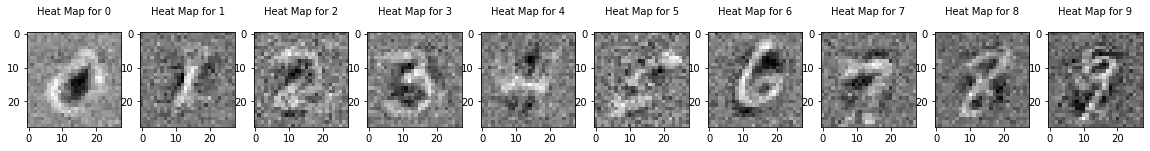

In [19]:
# Average weight over the graph
weights = np.array(weights) # weights have shape (10, 784+1, 10)
avg_weights = weights.mean(axis=0).transpose() # avg_weights have shape (10, 784+1)

plt.figure(figsize=(20,10))
for index, avg_weight in enumerate(avg_weights):
    plt.subplot(1, 10, index + 1)
    avg_weight = avg_weight[1:] # we don't need to visualize the bias
    plt.imshow(avg_weight.reshape([28, 28]), cmap=plt.cm.gray)
    plt.title('Heat Map for %i\n' % index, fontsize = 10)

### 1.6 Results Visualization

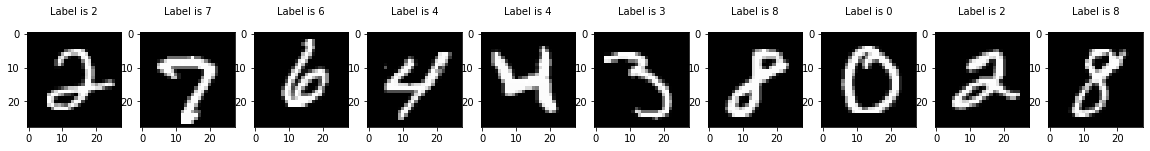

In [20]:
visualization_index = np.random.randint(0,100,10)
# we will predict using the average weights over all 10 folds
test_prediction = predict(weights.mean(axis=0), x[visualization_index])
plt.figure(figsize=(20,10))
for index, (image, label) in enumerate(zip(x[visualization_index], test_prediction)):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image.reshape([28, 28])*255, cmap=plt.cm.gray)
    plt.title('Label is %i\n' % label, fontsize = 10)